# Polytech'Nice Deep Learning course 2023

## Introduction:
Ce rapport détaille les étapes que nous avons suivies dans la classification des Pokémon. L'objectif est de construire un modèle capable de reconnaître les Pokémon et de prédire leurs “labels”. Nous utilisons le jeu de données RoboFlow. Pokedex. Le dataset contient autour de 7000 images dans 151 classes qui representent chacun un nom de Pokemon.

## Auteurs:

  -   M'nasri Yasmina.
  -  El Baali Basma.


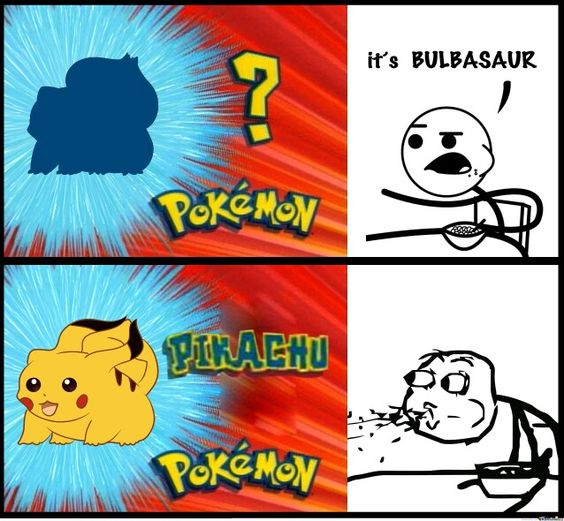

- La tâche qui nous attend n'est certainement pas facile ; néanmoins, commençons ! ✨

## Les librairies:

Le code commence par importer les bibliothèques nécessaires, notamment PIL (Pillow) pour le traitement d'images, os pour la manipulation de fichiers et de répertoires, pandas pour la manipulation de données tabulaires, matplotlib.pyplot pour la visualisation, et IPython.display pour afficher des images dans un environnement IPython.
On utilise PyTorch pour la création et l'entraînement de modèles de réseaux neuronaux, en mettant l'accent sur la vision par ordinateur. Il importe des modules pour les tensors, les couches de réseau, les optimiseurs, les architectures pré-entraînées, les transformations d'images.


In [2]:
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

## Examinons les données

La fonction ci-dessous, load_images_and_labels, prend en entrée le chemin du répertoire d'images (image_dir) et le chemin du fichier CSV contenant les noms et les ID des Pokémon (csv_file). Elle crée une correspondance entre les noms de Pokémon et les ID, puis itère à travers le répertoire d'images pour collecter les chemins d'images et les étiquettes associées.
On crée donc un dataset associant chaque chemin d'image à son étiquette.

In [3]:
def load_images_and_labels(image_dir, csv_file):
    # Read the CSV file containing Pokemon names and IDs
    pokemon_df = pd.read_csv(csv_file, header=None, names=['ID', 'Name'])

    # Create a mapping from Pokemon names to Pokedex IDs
    name_to_id = dict(zip(pokemon_df['Name'], pokemon_df['ID']))

    # Initialize empty lists to store image paths and labels
    image_paths = []
    labels = []

    # Iterate through the image directory
    for root, dirs, files in os.walk(image_dir):
        for filename in files:
            # Get the Pokemon name from the directory name
            pokemon_name = os.path.basename(root)
            
            # Get the corresponding Pokedex ID using the mapping
            pokemon_id = name_to_id.get(pokemon_name)
            
            # Check if the Pokemon ID is valid
            if pokemon_id is not None:
                # Construct the full path to the image
                image_path = os.path.join(root, filename)
                
                # Append the image path and label to the lists
                image_paths.append(image_path)
                labels.append(pokemon_id)
    
    
    return image_paths, labels, pokemon_df

# Example usage:
image_dir = '/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/trainval/'
csv_file = '/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/pokemon_ids.csv'

# Visualize the first image in Colab using the display function
image_paths, labels, pokemon_df = load_images_and_labels(image_dir, csv_file)

dataset = []

# Browse the labels and images simultaneously.
labels = [int(label) for label in labels]

for label, image in zip(labels,image_paths):
    # Create pair (image, label) and add it to dataset
    pair = [image, label]
    dataset.append(pair)


## Afficher 10 images aléatoires:

On utilise la bibliothèque Matplotlib pour créer une visualisation de 10 images Pokémon sélectionnées de manière aléatoire à partir de l'ensemble de données.

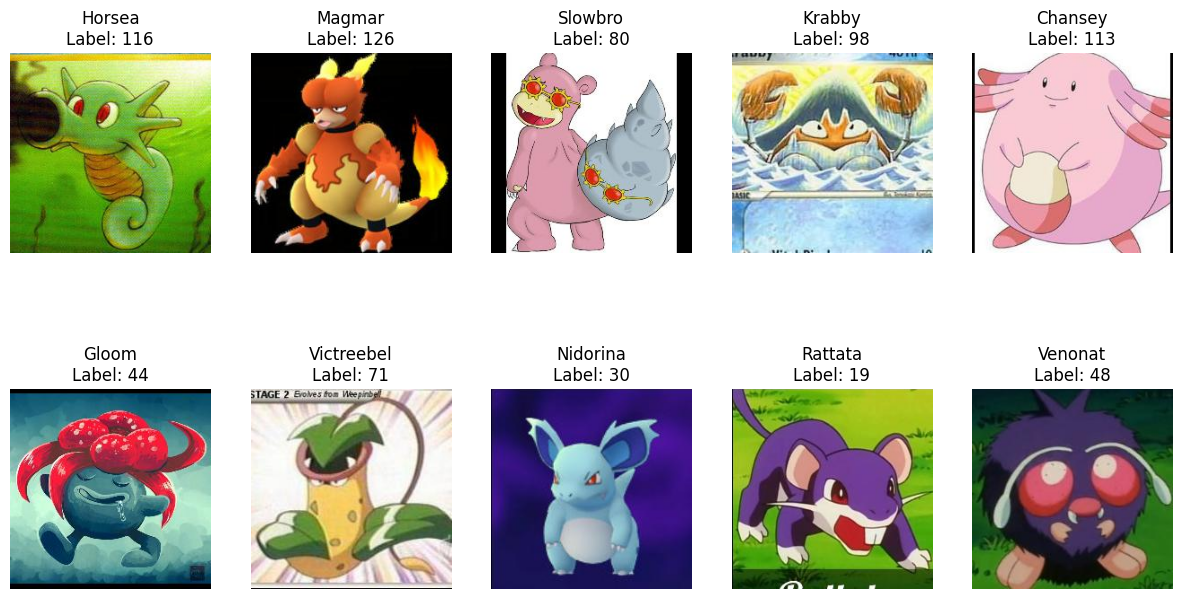

In [4]:
from IPython.display import display, Image as IPImage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Load images and labels
image_paths, labels, pokemon_df = load_images_and_labels(image_dir, csv_file)

# create a dictionary to put Pokemon's nouns associated to their labels
label_to_name = dict(zip(pokemon_df['ID'], pokemon_df['Name']))

#select randomly 10 Pokemns 
unique_labels = set(labels)
unique_labels_list = list(unique_labels)  # Convertir l'ensemble en liste
selected_labels = random.sample(unique_labels_list, min(10, len(unique_labels_list)))

#create a figure with a grid of 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(15, 8))

# plot informations for 10 selected Pokemon 
for i, label in enumerate(selected_labels):
    #Get the name associated to the label 
    pokemon_name = label_to_name[label]
    
    # Find all the indexes corresponding to the label
    indices = [index for index, l in enumerate(labels) if l == label]
    
    #choose an index randomly  
    index = random.choice(indices)
    
    # show image
    image_path = image_paths[index]
    img = mpimg.imread(image_path)
    
    # plot image with its name and label
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].set_title(f"{pokemon_name}\nLabel: {label}")
    axs[i // 5, i % 5].axis('off')

plt.show()

## Calculer les dimensions de toutes les images:


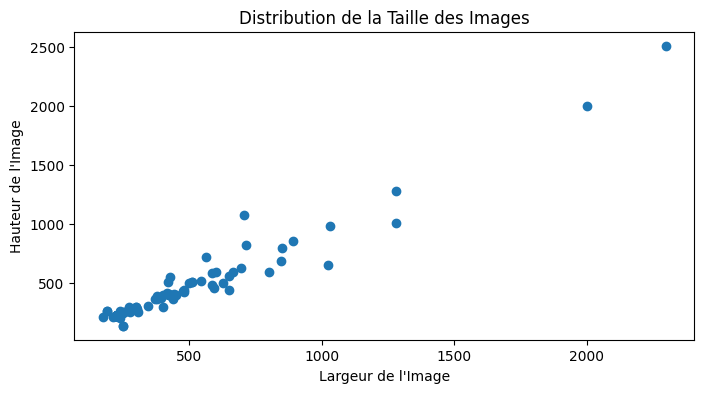

In [5]:
#compute dimensions of all images 
image_dimensions = [Image.open(image_path).size for image_path in image_paths]

#extract length and width 
widths, heights = zip(*image_dimensions)

# Visualize the distribution of the size of images
plt.figure(figsize=(8, 4))
plt.scatter(widths, heights)
plt.title('Distribution de la Taille des Images')
plt.xlabel('Largeur de l\'Image')
plt.ylabel('Hauteur de l\'Image')
plt.show()

**Aspect ratio :** La plupart des points se regroupent autour d'une ligne diagonale, cela peut indiquer que la plupart des images ont un aspect ratio similaire, rapports hauteur/largeur

**Gestion des tailles d'images :** On constate une grande variation dans les tailles d'images, cela peut influencer nos choix de stratégies de prétraitement. On va avoir besoin de redimensionner les images pour les rendre toutes de la même taille avant de les utiliser pour l'entraînement d'un modèle.

In [6]:
# statistics of the labels
label_counts = pd.Series(labels).value_counts()
print(label_counts)

105    58
65     55
45     53
143    53
123    50
       ..
142    31
12     30
104    29
63     29
74     28
Name: count, Length: 151, dtype: int64


## Division entre les données de validation et d'entraînement:

Il est habituel de diviser le jeu de données d'entraînement en deux ensembles distincts : l'ensemble d'entraînement et l'ensemble de validation.
Le réseau est formé sur l'ensemble d'entraînement, et ses performances sont évaluées à chaque époque en utilisant l'ensemble de validation.
Cette approche est utilisée pour prévenir le surajustement.

In [7]:
# Percentage of validation data
validation_split = 0.1

N_val_samples = round(validation_split * len(dataset))

## Split into two Subset
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - N_val_samples, N_val_samples])


## Data transformation:

Afin d'obtenir une meilleure précision et d'améliorer la robustesse de notre modèle, nous avons choisi d'appliquer une augmentation de données en utilisant torchvision.transforms et transforms.Compose(). Cela aidera également notre modèle à apprendre davantage de caractéristiques sur nos données. Voici une explication de chaque étape de la transformation :

*     **Resize()**: redimensionne l'image d'entrée à une taille de 240x240.

*     **RandomHorizontalFlip()**: inverse aléatoirement les images avec une probabilité de 0,5, ajoutant des images miroir à notre ensemble de données.

*     **Normalize**: normalise le tenseur et standardise les valeurs de pixel pour avoir une moyenne de 0 et un écart-type de 1.

Nous avons également essayé d'autres techniques telles que ColorJitter, RandomRotation et RandomResizedCrop, mais nous les avons supprimées car elles n'ont pas entraîné d'augmentation de la précision.

In [8]:
# Define data transformations for ResNet-50
transform = transforms.Compose([
    transforms.Resize((240,240)),#taille de l'image avant 240,240
    transforms.RandomHorizontalFlip(), #p=1
    #transforms.RandomRotation(degrees=66),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

## Création d'un Dataset Personnalisé avec PyTorch:

Cette classe hérite de la classe Dataset de PyTorch et est utilisée pour créer des ensembles de données personnalisés (train_custom_dataset et val_custom_dataset).

La méthode __init__ initialise l'objet avec le jeu de données et une transformation optionnelle à appliquer aux images.

La méthode __len__ renvoie la taille du jeu de données.

La méthode __getitem__ retourne une paire (image, label) pour un index donné. Elle ouvre l'image à partir du chemin spécifié et applique éventuellement la transformation.

Deux instances de la classe CustomDataset sont créées : train_custom_dataset pour l'ensemble d'entraînement et val_custom_dataset pour l'ensemble de validation.
Elles seront utilisées ultérieurement pour créer des DataLoader et fournir des données au modèle lors de l'entraînement et de l'évaluation.

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image_path, label = self.dataset[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label
# Create a custom dataset
train_custom_dataset = CustomDataset(train_data, transform)
val_custom_dataset = CustomDataset(val_data, transform)

## Les DataLoaders:

Ce code crée des DataLoaders en utilisant la bibliothèque PyTorch. Les DataLoaders sont utilisés pour préparer les données d'entraînement et de validation de manière à les rendre facilement accessibles pour l'entraînement du modèle. Il générera automatiquement des lots de données pour chaque itération lors de l'entraînement.

* **'batch_size'** spécifie le nombre d'échantillons d'entraînement que le modèle utilisera à chaque itération de l'entraînement. En expérimentant avec différentes tailles de lots celle qui fonctionne le mieux pour notre problème en particulier est 3, permettant une meilleure accuracy. Le modèle semble sensible à la variabilité des échantillons dans chaque lot et des lots plus petits peuvent permettre au modèle de converger plus rapidement. 

* **'shuffle=True'** indique au DataLoader de mélanger les données à chaque époque d'entraînement. Cela aide le modèle à ne pas mémoriser l'ordre des échantillons et à mieux généraliser.









In [10]:
# Create a DataLoader for batching and shuffling
batch_size = 3
dataloader = DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_custom_dataset, batch_size=batch_size, shuffle=True)

## Utilisation du GPU:

Les GPU sont conçus pour effectuer rapidement des calculs sur des matrices, ce qui est une opération courante dans les opérations d'apprentissage en profondeur. Par rapport aux CPU (Central Processing Unit) traditionnels, les GPU peuvent effectuer de nombreuses opérations en parallèle, ce qui accélère considérablement l'entraînement des modèles.
Dans ce code, on vérifie si un GPU (CUDA) est disponible sur la machine. Si c'est le cas, le modèle sera chargé sur le GPU, sinon, il sera chargé sur le CPU.

## Modèle Resnet:

Nous avons d'abord envisagé de construire un modèle CNN (Convolutional Neural Network) à partir de zéro. Nous avons alors définie un modèle relativement simple avec un nombre limité de couches (3) et de paramètres. Nous avons compris que ce n'était pas suffisant pour capturer des motifs complexes dans les données. Cela nous donnait une accuracy de 20%. Pour pouvoir augmenter cette accuracy, on a besoin d'un modèle plus profond ce qui nécessite beaucoup de temps, de ressources computationnelles et de données. On a finalement choisi d'utiliser des modèles pré-entraînés.

ResNet-50 est une architecture de réseau de neurones profonds composée de 50 couches. Son architecture se distingue par l'utilisation de blocs résiduels qui facilitent l'apprentissage en profondeur. Il s'agit du modèle avec lequel nous obtenons la meilleure accuracy.

Nous avons testé ResNet-101 et ResNet-152 qui sont des variantes plus profondes de ResNet-50, mais une plus grande profondeur n'a pas garantit de meilleures performances, et cela a même entraîné des problèmes de surajustement(overfitting) et une augmentation du temps de compilation.

ResNet-50 offre un équilibre entre capacité de représentation (due à sa profondeur) et complexité du modèle. Il est suffisamment profond pour capturer des caractéristiques complexes, mais n'est pas aussi coûteux en termes de ressources que des architectures plus grandes comme ResNet-101 ou ResNet-152.

Lorsqu'on a observé le modèle ResNet-18, nous avons eu une moins bonne accuracy mais un temps d'entraînement plus rapide. ResNet-18 est moins profond que ResNet-50, ce qui signifie qu'il a moins de paramètres à entraîner.

Dans le code ci-dessous on utilise la bibliothèque PyTorch pour charger un modèle ResNet-50, puis on modifie la dernière couche du modèle, model.fc, qui est une couche linéaire (fully connected) qui doit être adaptée au nombre de classes spécifié.






In [11]:
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load a pre-trained ResNet-50 model
    model = models.resnet50(pretrained=True)

    # Modify the last layer for your classification task
    num_classes = 152  # Number of Pokemon classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s] 


## Optimizer et loss function:
Nous avons choisi **nn.CrossEntropyLoss()** comme fonction de perte et **optim.SGD(model.parameters(), lr=0.001, momentum=0.9)** car ils sont bien adaptés aux problèmes de classification multi-classes.
- La fonction de coût combine l'activation softmax et la perte de vraisemblance négative en une seule formule efficace.

-  SGD avec momentum permet de mieux converger grâce à sa nature stochastique.

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## LR scheduler:
Nous avons ajouté un planificateur **LambdaLR** afin d'ajuster le taux d'apprentissage pendant l'entraînement. Cette méthode fixe le taux d'apprentissage de chaque groupe de paramètres au taux d'apprentissage initial multiplié par le facteur 0,85 à la puissance de l'époque.

Nous avons également essayé différents planificateurs de taux d'apprentissage tels que MultiplicativeLR et StepLR, mais **LambdaLR** nous a donné la meilleure précision.

In [13]:
#Add LambdaLR for learning rate scheduling
lam = lambda epoch: 0.85 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lam)


## Boucle d'entraînement et de validation:
 
Ce code représente la phase d'entraînement d'un modèle d'apprentissage sur l'ensemble de données. Pendant un certain nombre d'époques, le modèle est ajusté aux données d'entraînement en minimisant une fonction de perte.

Dans le cadre de notre processus d'optimisation du modèle, nous avons entrepris une série d'expérimentations pour déterminer le nombre optimal d'époques à utiliser lors de l'entraînement. 

Après avoir évalué différentes configurations, nous avons constaté que l'accuracy du modèle atteint son optimum avec 13 époques. Plus précisément, nous avons observé que l'accuracy n'augmentait plus au-delà de ce nombre d'époques, et qu'une augmentation supplémentaire pouvait même entraîner une légère dégradation des performances. 

In [14]:
# Train the model
num_epochs = 13
all_labels = []
all_predictions = []
epoch_val_loss = []
epoch_val_acc = []
epoch_loss = []
epoch_acc = []
for epoch in range(num_epochs):
    print("epoch :", epoch)
    running_loss = 0.0
    running_accuracy = 0
    model.train()
    for i, batch in enumerate(tqdm(dataloader)):
        x = batch[0].to(device)  # Move input to GPU
        labels = batch[1].to(device)
        outputs = model(x)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():

            running_loss += loss.item()
            running_accuracy += (outputs.max(1)[1] == labels).sum().item()
    # Update the learning rate at the end of each epoch
    scheduler.step()

    print("Training Accuracy:",running_accuracy / float(len(train_data)),"Training Loss:", running_loss/float(len(train_data)))
    epoch_loss.append(running_loss / len(train_data))
    epoch_acc.append(running_accuracy/len(train_data))
    #validation loop
    model.eval()
    running_val_loss = 0  # Initialiser test_loss à zéro
    running_val_accuracy = 0
    for i, batch in enumerate(tqdm(val_dataloader)):

        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0].to(device)  # Move input to GPU
            labels = batch[1].to(device)  # Move labels to GPU

            # Compute the network output
            y = model(x)

            # Compute the loss
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()

            # Collect labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(y.max(1)[1].cpu().numpy())
        
    print("Validation accuracy:", running_val_accuracy/float(len(val_data)),
          "Validation loss:", running_val_loss/float(len(val_data)))       
    epoch_val_loss.append(running_val_loss/len(val_data))
    epoch_val_acc.append(running_val_accuracy/len(val_data))
    



epoch : 0


100%|██████████| 1807/1807 [01:44<00:00, 17.28it/s]


Training Accuracy: 0.26605166051660517 Training Loss: 1.1678142207520035


100%|██████████| 201/201 [00:04<00:00, 44.22it/s]


Validation accuracy: 0.7890365448504983 Validation loss: 0.28134865417265864
epoch : 1


100%|██████████| 1807/1807 [01:34<00:00, 19.04it/s]


Training Accuracy: 0.7568265682656826 Training Loss: 0.3760025775496508


100%|██████████| 201/201 [00:04<00:00, 43.54it/s]


Validation accuracy: 0.9102990033222591 Validation loss: 0.11389677677718064
epoch : 2


100%|██████████| 1807/1807 [01:36<00:00, 18.67it/s]


Training Accuracy: 0.9040590405904059 Training Loss: 0.16784196046638092


100%|██████████| 201/201 [00:04<00:00, 43.96it/s]


Validation accuracy: 0.9269102990033222 Validation loss: 0.08442739667383727
epoch : 3


100%|██████████| 1807/1807 [01:37<00:00, 18.51it/s]


Training Accuracy: 0.9529520295202952 Training Loss: 0.09466536693701115


100%|██████████| 201/201 [00:04<00:00, 43.37it/s]


Validation accuracy: 0.9601328903654485 Validation loss: 0.05393740277757394
epoch : 4


100%|██████████| 1807/1807 [01:37<00:00, 18.61it/s]


Training Accuracy: 0.9747232472324723 Training Loss: 0.06013791152496042


100%|██████████| 201/201 [00:04<00:00, 43.48it/s]


Validation accuracy: 0.9501661129568106 Validation loss: 0.06087901668703591
epoch : 5


100%|██████████| 1807/1807 [01:37<00:00, 18.51it/s]


Training Accuracy: 0.979520295202952 Training Loss: 0.04724884120321307


100%|██████████| 201/201 [00:04<00:00, 43.56it/s]


Validation accuracy: 0.9551495016611296 Validation loss: 0.051001363244752816
epoch : 6


100%|██████████| 1807/1807 [01:37<00:00, 18.51it/s]


Training Accuracy: 0.9863468634686346 Training Loss: 0.034103103616529205


100%|██████████| 201/201 [00:04<00:00, 42.31it/s]


Validation accuracy: 0.973421926910299 Validation loss: 0.041573810827271566
epoch : 7


100%|██████████| 1807/1807 [01:36<00:00, 18.64it/s]


Training Accuracy: 0.9874538745387453 Training Loss: 0.030453770992224106


100%|██████████| 201/201 [00:04<00:00, 43.99it/s]


Validation accuracy: 0.9750830564784053 Validation loss: 0.0449516210530496
epoch : 8


100%|██████████| 1807/1807 [01:37<00:00, 18.63it/s]


Training Accuracy: 0.9902214022140221 Training Loss: 0.02439815164810026


100%|██████████| 201/201 [00:04<00:00, 43.48it/s]


Validation accuracy: 0.9651162790697675 Validation loss: 0.04879804820709682
epoch : 9


100%|██████████| 1807/1807 [01:37<00:00, 18.61it/s]


Training Accuracy: 0.9935424354243543 Training Loss: 0.02095639414937541


100%|██████████| 201/201 [00:04<00:00, 44.01it/s]


Validation accuracy: 0.9700996677740864 Validation loss: 0.051264760031639496
epoch : 10


100%|██████████| 1807/1807 [01:36<00:00, 18.66it/s]


Training Accuracy: 0.994649446494465 Training Loss: 0.017672501724020913


100%|██████████| 201/201 [00:04<00:00, 43.08it/s]


Validation accuracy: 0.96843853820598 Validation loss: 0.048271610823550845
epoch : 11


100%|██████████| 1807/1807 [01:37<00:00, 18.54it/s]


Training Accuracy: 0.9964944649446494 Training Loss: 0.0155527629522904


100%|██████████| 201/201 [00:04<00:00, 43.60it/s]


Validation accuracy: 0.9750830564784053 Validation loss: 0.0476723060645607
epoch : 12


100%|██████████| 1807/1807 [01:36<00:00, 18.63it/s]


Training Accuracy: 0.9955719557195571 Training Loss: 0.015032729872728344


100%|██████████| 201/201 [00:04<00:00, 43.75it/s]

Validation accuracy: 0.9601328903654485 Validation loss: 0.048810809235643036


## Matrice de confusion:

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

# Sample code, adjust as needed
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Choose the first 10 classes (adjust indices as needed)
selected_classes = range(10)

# Extract the subset of the confusion matrix
conf_matrix_subset = conf_matrix[selected_classes, :][:, selected_classes]

# If you have class names, use them
class_names_subset = [str(i) for i in selected_classes]

# Normalize the matrix if needed
normalized_conf_matrix = conf_matrix_subset / conf_matrix_subset.sum(axis=1, keepdims=True)

# Create a figure
fig = ff.create_annotated_heatmap(z=normalized_conf_matrix, x=class_names_subset, y=class_names_subset, colorscale='Viridis')

# Add labels
fig.update_layout(
    xaxis=dict(title='Predicted Label'),
    yaxis=dict(title='True Label'),
    title='Confusion Matrix (Subset of 10 Classes)',
)

# Show the figure
fig.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


La matrice de confusion permet de visualiser ces informations sous forme de tableau, où chaque ligne représente les instances dans une classe réelle et chaque colonne représente les instances dans une classe prédite. Les diagonales de la matrice (de gauche en haut à droite) représentent les classifications correctes, tandis que les cellules en dehors de la diagonale représentent les erreurs de classification. 

### Visualisation du Training accuracy et Loss accuracy:

Nous pouvons visualiser la fonction de coût et l’accuracy au fil du temps par le bias de **Matplotlib**. C’est utile car nous pouvons repérer le moment de l’overfitting. Si la précision d'entraînement est significativement plus élevée que la précision de validation, cela pourrait signifier que le modèle surajuste (overfit).

Text(0.5, 1.0, 'Evolution of training Loss')

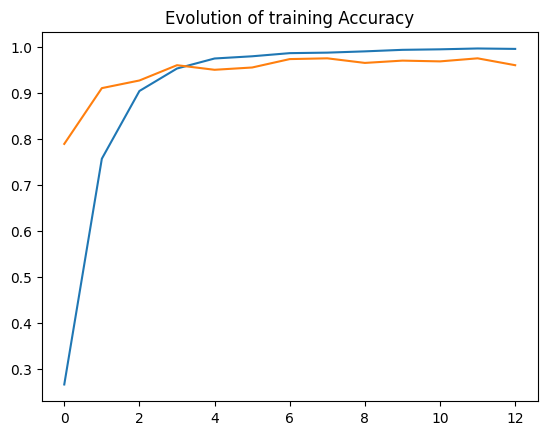

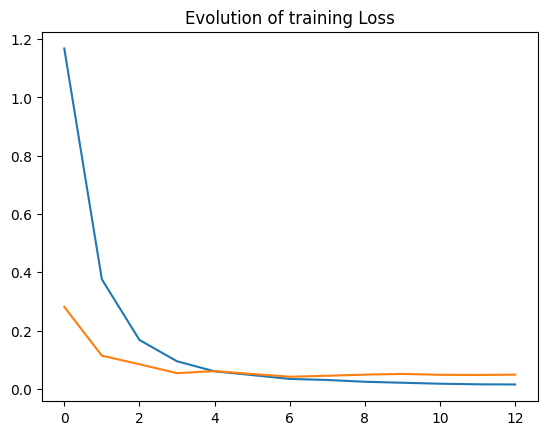

In [16]:
x= np.arange(num_epochs)
plt.figure()
plt.plot(x,epoch_acc,x,epoch_val_acc)
plt.title("Evolution of training Accuracy")

plt.figure()
plt.plot(x,epoch_loss,x,epoch_val_loss)
plt.title("Evolution of training Loss")

## Prétraitement et Inférence sur un ensemble d'Images de Test:

Ce code a pour objectif de charger un ensemble d'images de test à partir d'un répertoire spécifié, à l'exclusion d'une image particulière identifiée par son indice. 
Ensuite, une fonction de conversion est définie pour transformer ces images au format PIL (Python Imaging Library) en tenseurs utilisables pour l'inférence par un modèle d'apprentissage en profondeur.
Enfin, une fonction de conversion transform est définie à l'aide de transforms.Compose de la bibliothèque torchvision. Cette fonction effectue des opérations de redimensionnement, de conversion en tenseur et de normalisation sur les images. Une liste vide predicted_labels est également créée pour stocker les étiquettes prédites par un modèle sur ces images de test.


In [17]:
# create a list to store images
test_images = []

#Define the directory path containing test images
directory_path = '/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/test/'


#Set the number of images you want to load
num_images = 1000  # Par exemple, si vous avez 105 images de test
# Indice de l'image à exclure
exclude_image_index = 890
# Utilisez une boucle pour charger les images
for i in range(num_images):
    if i != exclude_image_index:
        file_path = directory_path + f'{i}.jpg'
        image = Image.open(file_path)
        test_images.append(image)

## Create a conversion function to convert PIL images into Tensors
transform = transforms.Compose([transforms.Resize((240, 240)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
predicted_labels = []


## Affichage de 10 images avec leurs prédictions:

Le modèle est entraîné pour prédire des labels associés à des images de Pokémon, et le code affiche les 10 premières images de test avec les prédictions correspondantes.

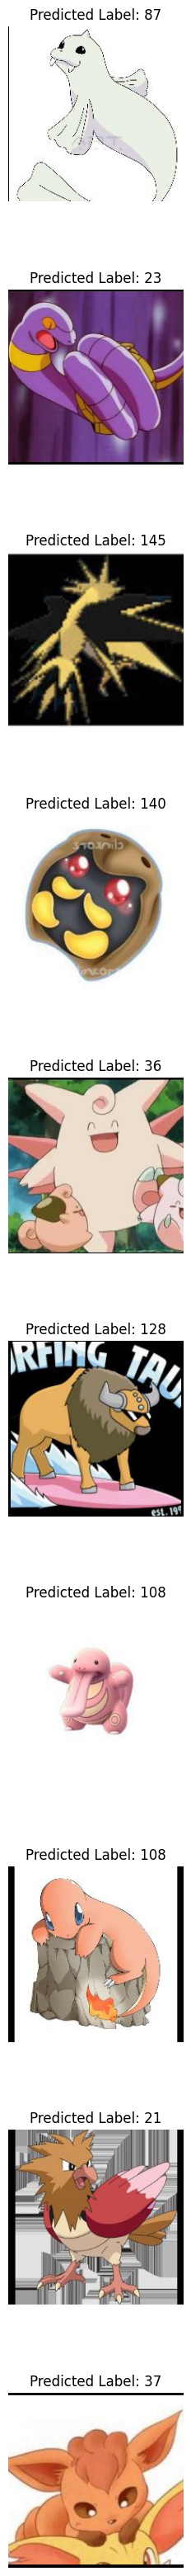

In [18]:
model.eval()  # Set the model to evaluation mode
model.to(device)
# Iterate through the test images and make predictions
with torch.no_grad():
    for image in test_images:
        image = transform(image).unsqueeze(0).to(device)  # Ajoutez une dimension de lot et déplacez sur le GPU
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.append(predicted.item())
    

# Créez une figure avec des sous-graphiques pour afficher les images
fig, axes = plt.subplots(10, 1, figsize=(4, 4*10))

# Itération à travers les 10 premières images et leur predictions
for i in range(10):
    axes[i].imshow(test_images[i])
    axes[i].set_title(f'Predicted Label: {predicted_labels[i]}')
    axes[i].axis('off')
    

plt.subplots_adjust(hspace=0.5)
plt.show()




## Création du csv file:

Ce script Python crée un fichier CSV contenant des prédictions de labels pour des images. Il utilise le module CSV pour gérer les opérations sur le fichier. L'image 890 n'a pas eu de prédiction car il y a une erreur de dimension en rentrant l'image dans le modèle.

In [19]:
# creer le csv.file
import csv


# Define the CSV file path where you want to save the results
csv_file_path = '/kaggle/working/predicted_labels15.csv'

# Create a list of filenames and their corresponding predicted_labels
file_names = [f'{i}.jpg' for i in range(num_images) if i != exclude_image_index]


# Create a list of tuples containing (filename, predicted_label)
data = list(zip(file_names, predicted_labels))

# Insert the prediction for image 890 that doesn't have a prediction
data.insert(890, ('890.jpg', ''))

# Write the data to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['filename', 'pokemon_id']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i, (filename, label) in enumerate(data):
        writer.writerow({'filename': filename, 'pokemon_id': label})
        

print(f"Predicted labels saved to {csv_file_path}")



Predicted labels saved to /kaggle/working/predicted_labels15.csv


## Conclusion:

Pendant cette compétition, nous avons exploré différentes techniques pour augmenter la précision et améliorer les performances de notre modèle, que ce soit en modifiant l'ensemble du modèle lui-même ou en ajoutant de nouveaux éléments tels que l'augmentation de données ou le programmateur du taux d'apprentissage (**Learning rate**). Examinant de plus pres les etapes que nous avons suivies:

Tout d'abord, nous avons créé notre modèle de réseau neurone  en nous inspirant de ce que nous avons fait lors de la session d'apprentissage profond dans le laboratoire 2. Ensuite, nous avons décidé d'utiliser un modèle pré-entraîné tel que **ResNet-50** et avons obtenu de bons résultats. Nous avons également testé **ResNet-101** et **ResNet-152**. Malheureusement, comme nous l'expliquons dans la partie sur la boucle d'apprentissage, cela prend soit trop de temps à compiler, soit conduit au surajustement (**Overfitting**). Nous avons donc conservé ResNet-50. En utilisant la visualisation de la précision et de la perte d'entraînement, nous avons déterminé que le nombre optimal d'époques était de 13, car choisir un nombre plus élevé n'augmentait pas la précision. Nous avons également effectué l'augmentation des données et programmé le taux d'apprentissage à l'aide de la fonction **LambdaLR**. Toutes ces méthodes combinées nous ont permis d'atteindre une précision de **0,97200**.